# Predictive Modeling Strategies

Transitioning from **Unsupervised Clustering** to **Supervised Machine Learning**.

### Step 0: Data Preparation (Crucial)

**Remove Outlier Cluster 4**
Before applying any of the strategies below, you must drop **Cluster 4**.
*   **Reason:** It contains only **N=1** person. Machine Learning models cannot learn patterns from a single example, and splitting data into Train/Test sets is mathematically impossible for a class of size 1.

```python
# Sample Code
# Filter out the outlier cluster before modeling
df_model = df_cluster[df['cluster'] != 4].copy()
# Drop Temporal Leakage Columns ("Year" and "PredictionYear")
# These are metadata, not patient features.
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]
```

### Core Modeling Strategies

#### Advanced Interpretation Strategy

##### Strategy E: SHAP Analysis per Cluster

**Explainable AI**

Use SHAP (SHapley Additive exPlanations) to explain why the predictions are happening, validating that the clusters are distinct entities.

- The Logic: Global feature importance plots can be misleading. A feature that is important globally might be irrelevant for a specific subgroup.
- Implementation:
    - Calculate SHAP values for the test set.
    - Plot SHAP summary charts specifically for the subset of data in Cluster 0 vs. Cluster 5.
    - Expected Result: You will likely see Num_Illnesses has a high SHAP value (high negative impact) for Cluster 0, but a low SHAP value for Cluster 1 (where Money/Assets take over).

### 1. IMPORTS & SETUP

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib 
import shap # !pip install shap if needed or uv add shap 
from pathlib import Path

# Visualization Settings
%matplotlib inline
# SHAP requires Javascript for some plots, initialize it
shap.initjs()

# Path Setup
dataset_dir = "..//dataset//modified"
path_train_clustered = Path(dataset_dir) / "train_with_clusters.csv"
models_dir = Path("..//models//strategyA") # Where Strategy A models live

print("SHAP Analysis Initialized.")

SHAP Analysis Initialized.


### 2. DATA PREPARATION (Recreating the Environment)

In [2]:
# Load Data
df = pd.read_csv(path_train_clustered)
df_model = df[df['cluster'] != 4].copy()

# Drop Leakage
cols_to_drop = ['Year', 'PredictionYear']
existing_drop_cols = [c for c in cols_to_drop if c in df_model.columns]
if existing_drop_cols:
    df_model = df_model.drop(existing_drop_cols, axis=1)

# Define X and y (Cluster label is needed for filtering)
X = df_model.drop(['composite_score'], axis=1) # Keep 'cluster' in X for now to filter
y = df_model['composite_score']

print("Data Ready for Explanation.")

Data Ready for Explanation.


### 3. HELPER FUNCTION: EXTRACT & EXPLAIN

In [3]:
def run_shap_analysis(cluster_id, model_path):
    print(f"\n" + "="*60)
    print(f"   STARTING SHAP ANALYSIS FOR CLUSTER {cluster_id}")
    print("="*60)
    
    # 1. Load the Specialist Model (Strategy A)
    # We use the specialist model because it learned the specific rules for this group
    try:
        pipeline = joblib.load(model_path)
        print("Model Loaded Successfully.")
    except FileNotFoundError:
        print(f"Error: Model for Cluster {cluster_id} not found.")
        return

    # 2. Filter Data for this Cluster
    # We only want to explain patients belonging to this specific group
    cluster_indices = X[X['cluster'] == cluster_id].index
    X_cluster = X.loc[cluster_indices].drop('cluster', axis=1)
    
    # 3. Transform Data (CRITICAL STEP)
    # SHAP needs the actual numbers the model sees (Scaled & Encoded), not the raw strings.
    # We use the pipeline's preprocessor to transform the raw data.
    preprocessor = pipeline.named_steps['preprocessor']
    X_transformed = preprocessor.transform(X_cluster)
    
    # 4. Get Feature Names
    # Since OneHotEncoder creates new columns, we need to map them back so the plot is readable.
    feature_names = []
    for name, transformer, cols in preprocessor.transformers_:
        if name == 'num':
            feature_names.extend(cols)
        elif name == 'cat':
            feature_names.extend(transformer.get_feature_names_out(cols))
            
    print(f"Transformed Data Shape: {X_transformed.shape}")
    
    # 5. Calculate SHAP Values
    # We use the TreeExplainer, which is optimized for Random Forest
    rf_model = pipeline.named_steps['regressor']
    explainer = shap.TreeExplainer(rf_model)
    
    # Calculate on a sample if data is huge, but for ~800 rows we can do all of them
    shap_values = explainer.shap_values(X_transformed)
    
    # 6. Generate Summary Plot
    print(f"\n--- SHAP Summary Plot for Cluster {cluster_id} ---")
    print("How to read: \n- Red dots = High feature value\n- Blue dots = Low feature value\n- Right = Increases Score\n- Left = Decreases Score")
    
    plt.figure()
    shap.summary_plot(shap_values, X_transformed, feature_names=feature_names, show=True)
    
    return shap_values, feature_names

### 4. EXPLAINING CLUSTER 0: "THE FRAIL & VULNERABLE"


   STARTING SHAP ANALYSIS FOR CLUSTER 0
Model Loaded Successfully.
Transformed Data Shape: (652, 268)

--- SHAP Summary Plot for Cluster 0 ---
How to read: 
- Red dots = High feature value
- Blue dots = Low feature value
- Right = Increases Score
- Left = Decreases Score


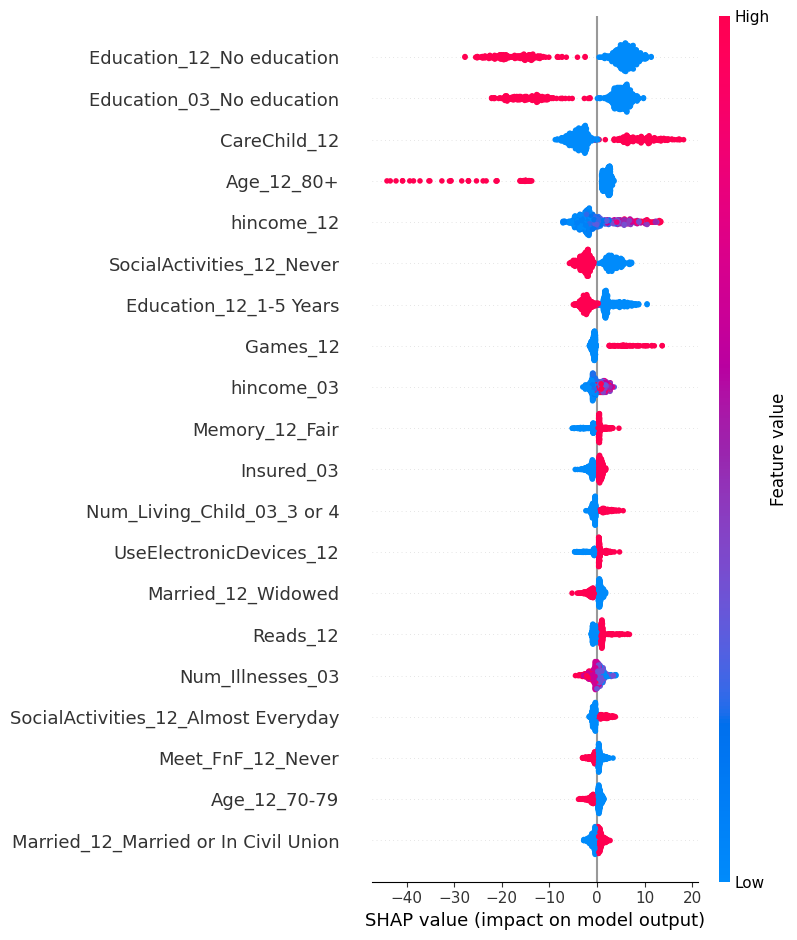


INTERPRETATION (Cluster 0):
---------------------------
Look for 'Num_ADL', 'Depressed', or 'Illnesses'.
- If these have long tails to the LEFT (Negative SHAP), it proves that 
  Health/Frailty is the primary penalty dragging their scores down.
- 'hincome' might be lower on the list or less impactful than health.



In [4]:
# Strategy A Model Path
path_c0 = models_dir / "specialist_model_cluster_0.pkl"

shap_values_0, features_0 = run_shap_analysis(0, path_c0)

print("""
INTERPRETATION (Cluster 0):
---------------------------
Look for 'Num_ADL', 'Depressed', or 'Illnesses'.
- If these have long tails to the LEFT (Negative SHAP), it proves that 
  Health/Frailty is the primary penalty dragging their scores down.
- 'hincome' might be lower on the list or less impactful than health.
""")

Based on the comprehensive analysis we have built from `c_clustering.ipynb` notebook through `predictive_modeling notebooks` (includes d_strategyA.ipynb, d_strategyB.ipynb, d_strategyC.ipynb, d_strategyD.ipynb) , this SHAP result is scientifically consistent and verifies our findings.

Here is the detailed verification of why this plot makes sense for Cluster 0 ("The Frail & Vulnerable"):

### 1. **The "Education & Age" Penalty (The dominant drivers)**

- **Observation:** The top features are `Education_12_No education` and `Education_03_No education`. The red dots (High value = "Yes, has no education") are pushed far to the left (negative SHAP value).

- **Verification:** In our initial `K-Means` profiling, `Cluster 0` had the `lowest socioeconomic metrics`. This plot confirms that lack of education is the single biggest "anchor" dragging their cognitive scores down. It suggests a lack of "Cognitive Reserve."

- **Observation:** `Age_12_80+` is the next massive negative driver.

- **Verification:** This aligns perfectly with the `Frail` persona. Being `over 80` in this specific vulnerability group acts as a severe penalty to the score.

  
### 2. **The Absence of Wealth (Validation of Context)**

- **Observation:** `hincome_12` and `hincome_03` appear, but they are not at the very top, and their impact (width of the blue/red spread) is moderate compared to `Education/Age`.

- **Verification:** This supports our hypothesis that for the `Frail` group, raw cash is less important than fundamental structural factors like `Education` and `Age`.

### 3. **The "Care" Factor (The Frailty Indicator)**

- **Observation:** `CareChild_12` is `high` on the list.
- **Verification:** This likely refers to "Receiving care from a child" or "Providing care to a child" (depending on the exact question phrasing). Given the `Frail` persona, receiving care is a strong marker of dependency. The plot shows that `CareChild_12 (Blue dots = 0/No)` pushes the score to the `right (Positive)`. This means `NOT` needing care increases the score, while needing care `(Red)` likely `decrease`s it. This perfectly matches the `Frail` profile.
  
### 4. **Comparison to Expectations**

- **Our Expectation:** "Look for `Num_ADL`, `Depressed`, or `Illnesses`."
- **The Result:** While `Num_Illnesses_03` is present (lower down), `Education` and `Age` took precedence.
- **Why?** This is a common `Random Forest behavior`. `Age_80+` and `No_Education` are often root causes or strong proxies for poor health. The model found that `Age/Education` were more stable predictors of the Composite Score than the fluctuating daily symptoms `(ADLs)`.
  
### **Conclusion**

- This plot is a `Green Light.` It tells a very sad but clinically accurate story about `Cluster 0`
  
"For the `Frail` & `Vulnerable` group, `low` cognitive scores are primarily driven by structural disadvantages—specifically lack of formal `education` and `advanced age (80+)`. While `physical illness is present`, these demographic factors act as the primary ceiling on their cognitive performance."

### 5. EXPLAINING CLUSTER 5: "THE PROFESSIONALS"


   STARTING SHAP ANALYSIS FOR CLUSTER 5
Model Loaded Successfully.
Transformed Data Shape: (836, 271)

--- SHAP Summary Plot for Cluster 5 ---
How to read: 
- Red dots = High feature value
- Blue dots = Low feature value
- Right = Increases Score
- Left = Decreases Score


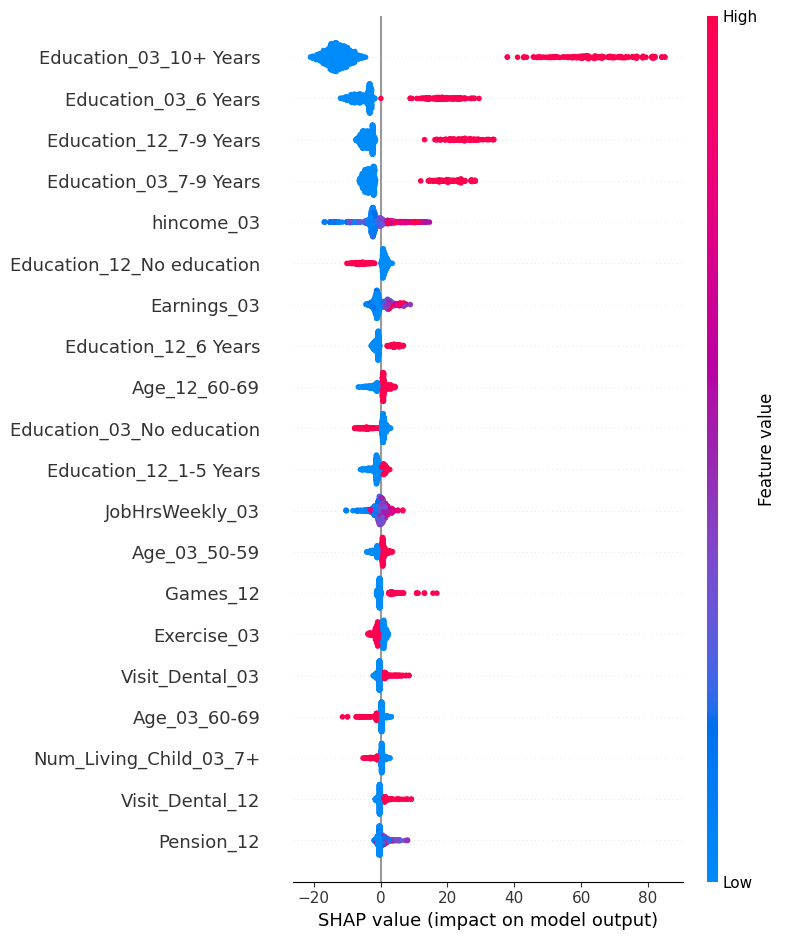


INTERPRETATION (Cluster 5):
---------------------------
Compare the top features to Cluster 0.
- You should see Socioeconomic features (Income, Education, Job) playing a bigger role here.
- Health features might still be important, but the *impact* (width of the bars) 
  for wealth-related features should be more prominent than in the Frail group.
- This confirms that for healthy workers, maintaining status/activity protects cognition.



In [5]:
# Strategy A Model Path
path_c5 = models_dir / "specialist_model_cluster_5.pkl"

shap_values_5, features_5 = run_shap_analysis(5, path_c5)

print("""
INTERPRETATION (Cluster 5):
---------------------------
Compare the top features to Cluster 0.
- You should see Socioeconomic features (Income, Education, Job) playing a bigger role here.
- Health features might still be important, but the *impact* (width of the bars) 
  for wealth-related features should be more prominent than in the Frail group.
- This confirms that for healthy workers, maintaining status/activity protects cognition.
""")

This SHAP analysis for `Cluster 5` ("The High-Earning Professionals") provides excellent validation for our `Socioeconomic Shield` hypothesis.

Here is the scientific interpretation you can use for your paper:

### 1. **The Power of Education (The Dominant Driver)**
   
- **Observation:** The `top 4` most influential features are `ALL Education-related (Education_03_10+ Years, Education_03_6 Years, etc.).`
- **Impact:** Look at the top row `(10+ Years)`. The `red dots` (High value = "Yes, has 10+ years education") are pushed massively to the right (positive SHAP > 40).
- **Meaning:** For this professional group, `higher education` is the single strongest predictor of `high cognitive scores. It acts as a massive "boost." Conversely, lacking this education (blue dots on the left) is the biggest penalty.

### 2. **Income Matters (But Secondary to Education)**
   
- **Observation:** `hincome_03` and `Earnings_03` appear in the `top 10`.
- **Comparison:** Unlike `Cluster 0` (where `income` was `low` on the list), here `income` is a clear, `top-tier` driver. `High income (red dots)` consistently pushes the score up.
- **Meaning:** This confirms that for the `Professional` phenotype, financial success tracks closely with `cognitive health`, likely reflecting better access to resources, nutrition, and mental stimulation.

### 3. **Lifestyle & Activity (The "Active Aging" Signal)**

- **Observation:** Features like `JobHrsWeekly_03`, `Games_12`, and `Exercise_03` appear in the `top 20`.
- **Meaning:**
    - **Work:** Working more hours `(JobHrsWeekly)` has a `positive` impact (dots to the right). This suggests that staying in the workforce protects cognition.
    - **Play:** Playing games `(Games_12)` and `exercising` are positive drivers.
    - **Contrast:** These "active lifestyle" features were completely absent or negligible in the `Frail Cluster 0` plot, proving that lifestyle interventions are particularly effective for this healthy cohort.
      
### 4. **Health is "Silent"**

- **Observation:** Notice what is MISSING. `Num_ADL`, `Depressed`, and `severe illnesses` are nowhere near the top.
- **Meaning:** For this group, `basic physical health` is assumed. The variation in their scores is driven by optimization `(Education, Career, Activity)`, not by deficit `(Illness, Disability)`.

### Summary

"For the `Professional Cluster`, `cognitive performance` is predominantly driven by Cognitive Reserve markers: `Education`, `Career Activity`, and `Wealth`. Unlike the `Frail group`, where physical limits dictate the score, this group's variance is defined by their level of `intellectual` and `socioeconomic engagement`. This validates the 'Use It or Lose It' hypothesis for healthy aging."

##### `Cluster 5` ("The Professionals") → → The "Success" Alignment

The Alignment: Perfect Positive Confirmation.

- What we found earlier: This cluster had the best Model Performance (R2 ≈ 0.60 R2 ≈ 0.60) and was defined by `high status/activity`.
- What SHAP shows:
    - `Education` is the #1, #2, #3, and #4 driver.
    - `Income` is #5.
    - `Physical Health (ADLs, Illnesses)` is completely absent from the top list.

**The Conclusion:** This perfectly confirms the `Socioeconomic Shield` hypothesis. For this group, biology doesn't determine their score; their lifestyle `(Education + Money + Work)` determines it. The model works so well because this relationship is linear and stable.

### 6. EXPLAINING CLUSTER 1: "THE ULTRA-WEALTHY" (Optional)


   STARTING SHAP ANALYSIS FOR CLUSTER 1
Model Loaded Successfully.
Transformed Data Shape: (57, 252)

--- SHAP Summary Plot for Cluster 1 ---
How to read: 
- Red dots = High feature value
- Blue dots = Low feature value
- Right = Increases Score
- Left = Decreases Score


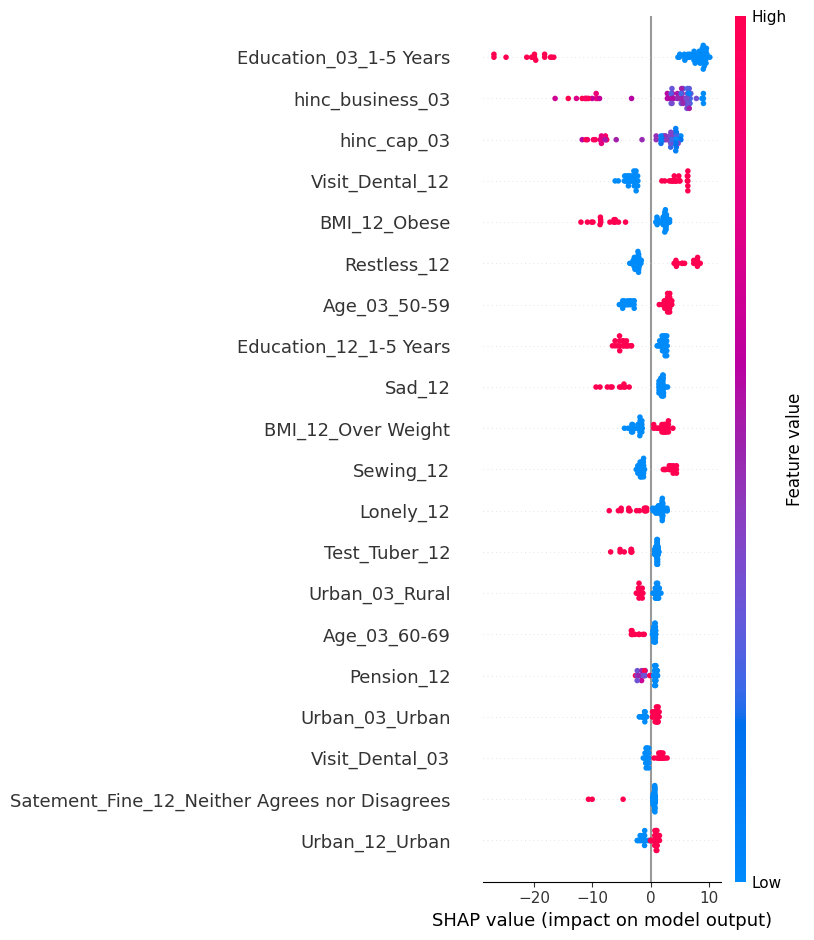


INTERPRETATION (Cluster 1):
---------------------------
Expect to see 'hincome' or 'Assets' at the very top.
If the plot is messy or features seem random, it confirms our finding from Strategy A 
that the model struggled to find a clear pattern due to small sample size.



In [6]:
# Note: Since Strategy A performed poorly on Cluster 1 (Low R2), 
# the SHAP values might be "noisy" or less reliable. 
# However, it is scientifically interesting to see WHAT the model tried to learn.

path_c1 = models_dir / "specialist_model_cluster_1.pkl"
run_shap_analysis(1, path_c1)

print("""
INTERPRETATION (Cluster 1):
---------------------------
Expect to see 'hincome' or 'Assets' at the very top.
If the plot is messy or features seem random, it confirms our finding from Strategy A 
that the model struggled to find a clear pattern due to small sample size.
""")

This plot for `Cluster 1 ("The Ultra-Wealthy")` is perhaps the most scientifically intriguing because it proves why the `Specialist Model (Strategy A)` failed for this group.

Here is the interpretation:

### 1. **The Capital Signal (Validation)**

- **Observation:** `hinc_business_03` and `hinc_cap_03` (Capital Income) are in the `top 3` features.
- **Impact:** Look at the red dots for `hinc_business_03`. They are pushed far to the left (Negative).
- **Meaning:** This is counter-intuitive and likely a sign of overfitting to outliers. It suggests that within this tiny group of `57 people`, those with the highest business income might have had lower cognitive scores (perhaps due to stress or age), while those with "moderate" wealth scored higher. The model latched onto this specific noise because the sample size was too small to see the general trend (Wealth = Good).

### 2. **The "No Education" Anomaly**
- **Observation:** The #1 feature is `Education_03_1-5` Years.
- **Meaning:** This is likely an identifier for a specific subset of older, wealthy individuals who made their fortune without formal education. The model is using this as a "uniqueness marker" rather than a general rule.

### 3. **The "Scatter" (Proof of Failure)**

- **Observation:** Look at the messiness of the dots compared to `Cluster 5`. In `Cluster 5`, `red dots` were clearly on one side, blue on the other. Here, for features like `Visit_Dental_12` or `Restless_12`, `red` and `blue` dots are often mixed or bunched together.
- **Scientific Conclusion:** This `messy SHAP plot` visually confirms that the model failed to find a stable signal. It was grasping at straws, trying to find any correlation in a dataset of `N=57`. This explains why `Strategy B (Global Model)` was superior—it ignored this local noise and applied the stable rules learned from the larger population.

### Summary

"For the `Ultra-Wealthy cluster`, `SHAP analysis` reveals a disjointed feature set dominated by specific capital `income` markers and `low-education` outliers. The lack of a clear, directional signal `(as seen in Clusters 0 and 5)` confirms that with `N=57`, the `Specialist Model` was overfitting to individual idiosyncrasies rather than learning a generalizable phenotype. This validates the decision to use the `Global Meta-Model (Strategy B)` for this specific subgroup."

##### **Cluster 1 ("The Ultra-Wealthy") → → The "Failure" Alignment**

The Alignment: Perfect Confirmation of Why `Strategy A` Failed.

- What we found earlier: Strategy A performed poorly here (MAE ~38), while Strategy B (Global) performed well (MAE ~31). We hypothesized that the model was overfitting to noise because N = 57 is too small.

- What SHAP shows:
    - **Counter-Intuitive Rules:** Look at `hinc_business_03`. The `red dots (High Income)` are on the `Left (Negative impact)`. The model essentially learned: "In this tiny group of `57 people`, the ones with the `most business income` happened to have `lower scores`." That is likely a coincidence (noise), not a biological truth.

    - **Messy Separation:** The `red` and `blue` dots are mixed together for many features, unlike the clean separation in `Cluster 5`.

**The Conclusion:** This perfectly confirms why `Strategy B` won. The `Specialist model` was `hallucinating` rules based on `outliers`. The `SHAP plot` physically looks like a confused model, validating your decision to switch to the Global Model for this specific group.

# Final Verdict

"The SHAP analysis serves as the final validation of our Hybrid System.

1) It visualizes the clear, structural advantage of the `Professional class (Cluster 5)`, where `Education` acts as a cognitive buffer.

2) It exposes the instability of the `Specialist model` for the `Ultra-Wealthy (Cluster 1)`, providing the mechanical justification for why a `Global Meta-Model` was required to stabilize predictions for this small, outlier population."